<a href="https://colab.research.google.com/github/HappyJJins/Jeju_CreditCard/blob/master/Submission0715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive

ROOT = '/content/drive'
drive.mount(ROOT)

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from os.path import join

MY_GOOGLE_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks/Jeju'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. 데이터 십만개 랜덤 샘플링


In [5]:
project_id = 'jeju-282707'
client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT 
      * 
  FROM `jeju-282707.jeju_data_ver1.201901_202003_train` 
  WHERE RAND() < 1000000 / (SELECT COUNT(*) FROM `jeju-282707.jeju_data_ver1.201901_202003_train`)
  ''').to_dataframe()

### 2. 데이터 전처리

#### 1) 날짜처리

In [6]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [7]:
data = train.copy()
data = data.fillna('')
data['REG_YYMM'].head()

0    201906
1    201901
2    201907
3    201906
4    201903
Name: REG_YYMM, dtype: int64

In [8]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,서울,광진구,버스 운송업,강원,원주시,10s,2,1,3,22500,3,2019,6
1,강원,횡성군,슈퍼마켓,강원,횡성군,10s,1,1,7,175340,23,2019,1
2,경기,광명시,한식 음식점업,강원,강릉시,10s,1,1,6,86600,6,2019,7
3,강원,강릉시,중식 음식점업,강원,강릉시,10s,2,1,11,143400,11,2019,6
4,서울,중구,택시 운송업,강원,삼척시,10s,1,1,3,14920,4,2019,3


#### 2) 지역민과 관광객으로 나누기

In [9]:
local = data[data['CARD_CCG_NM']==data['HOM_CCG_NM']].reset_index(drop=True)
tourist = data[data['CARD_CCG_NM']!=data['HOM_CCG_NM']].reset_index(drop=True)

#### 3) 시군구 제거

In [10]:
local, tourist = local.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1), tourist.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
local, tourist = local.groupby(columns).sum().reset_index(drop=False), tourist.groupby(columns).sum().reset_index(drop=False)

In [ ]:
len(data), len(local), len(tourist)

(1000290, 55636, 318948)

#### 4) 라벨 인코딩

In [11]:
dtypes_lcl = local.dtypes
encoders = {}
for column in local.columns:
    if str(dtypes_lcl[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(local[column])
        encoders[column] = encoder
        
lcl_num = local.copy()
for column in encoders.keys():
    encoder = encoders[column]
    lcl_num[column] = encoder.transform(local[column])

In [12]:
dtypes_trst = tourist.dtypes
encoders = {}
for column in tourist.columns:
    if str(dtypes_trst[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(tourist[column])
        encoders[column] = encoder
        
trst_num = tourist.copy()
for column in encoders.keys():
    encoder = encoders[column]
    trst_num[column] = encoder.transform(tourist[column])

#### 5) 데이터셋 분리
* 독립변수 VS 종속변수
* Train_data VS Test_data

In [13]:
from sklearn.model_selection import train_test_split

X_lcl, y_lcl = lcl_num.loc[:, lcl_num.columns != 'AMT'], lcl_num['AMT']
X_lcl = X_lcl.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train_lcl, X_test_lcl, y_train_lcl, y_test_lcl = train_test_split(X_lcl, y_lcl, test_size=0.3, random_state=126, shuffle=True)
X_train_lcl.shape, y_train_lcl.shape, X_test_lcl.shape, y_test_lcl.shape

((38714, 8), (38714,), (16592, 8), (16592,))

In [14]:
X_trst, y_trst = trst_num.loc[:, trst_num.columns != 'AMT'], trst_num['AMT']
X_trst = X_trst.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train_trst, X_test_trst, y_train_trst, y_test_trst = train_test_split(X_trst, y_trst, test_size=0.3, random_state=126, shuffle=True)
X_train_trst.shape, y_train_trst.shape, X_test_trst.shape, y_test_trst.shape

((222750, 8), (222750,), (95465, 8), (95465,))

#### 6) 종속변수의 로그변환 및 정규분포 적합

In [15]:
y_train_lcl, y_train_trst = np.log1p(y_train_lcl), np.log1p(y_train_trst)


 mu = 14.87 and sigma = 2.16



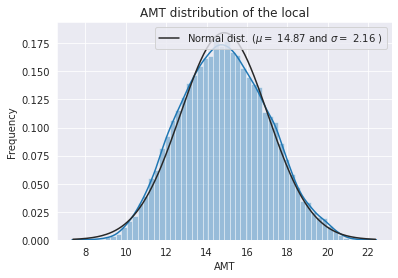

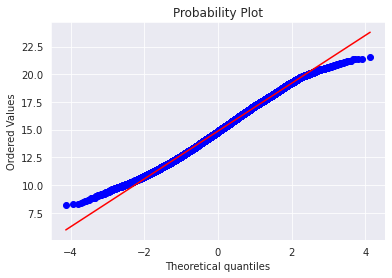

In [16]:
sns.distplot(y_train_lcl, fit=norm);
(mu, sigma) = norm.fit(y_train_lcl)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution of the local')

fig = plt.figure()
res = stats.probplot(y_train_lcl, plot=plt)
plt.show()


 mu = 14.87 and sigma = 2.16



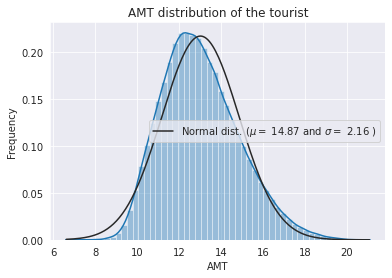

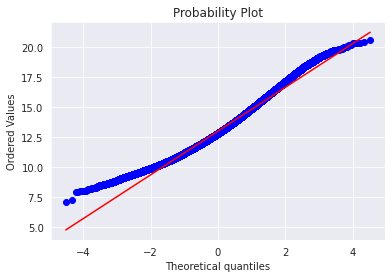

In [17]:
sns.distplot(y_train_trst, fit=norm);
(mu, sigma) = norm.fit(y_train_lcl)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution of the tourist')

fig = plt.figure()
res = stats.probplot(y_train_trst, plot=plt)
plt.show()

### 3. 교차검증 및 하이퍼 파라미터 튜닝

#### 1) RMSLE 성능 평가

In [18]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

2) XGBoost, LightGBM 설치

In [19]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

3) 모형 선언 및 학습

In [20]:
def lcl_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train_lcl, y_train_lcl)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test_lcl)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test_lcl, eval_pred)
  
  return cv_model.best_estimator_

In [21]:
def trst_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train_trst, y_train_trst)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test_trst)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test_trst, eval_pred)
  
  return cv_model.best_estimator_

In [22]:
from sklearn.linear_model import LinearRegression

xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb]
best_models_lcl = []
for model in models:
  new_model = lcl_best_params_model(model=model, params=params)
  best_models_lcl.append(new_model)

[00:22:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:22:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:24:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [23]:
from sklearn.linear_model import LinearRegression

xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb]
best_models_trst = []
for model in models:
  new_model = trst_best_params_model(model=model, params=params)
  best_models_trst.append(new_model)

[00:32:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:37:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:43:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

#### 4) 알고리즘 테스트

In [24]:
# lcl 모형 불러오기
xgb_reg_lcl = best_models_lcl[0]
gbm_reg_lcl = best_models_lcl[1]
lgb_reg_lcl = best_models_lcl[2]

# 예측 데이터 세트
xgb_pred_lcl = xgb_reg_lcl.predict(X_test_lcl)
xgb_pred_lcl = np.expm1(xgb_pred_lcl)

gbm_pred_lcl = gbm_reg_lcl.predict(X_test_lcl)
gbm_pred_lcl = np.expm1(gbm_pred_lcl)

lgb_pred_lcl = lgb_reg_lcl.predict(X_test_lcl)
lgb_pred_lcl = np.expm1(lgb_pred_lcl)

pred_lcl = np.array([xgb_pred_lcl, gbm_pred_lcl, lgb_pred_lcl])
print(pred_lcl.shape)

# transpose를 이용해 행과 열의 위치 교환
pred_lcl = np.transpose(pred_lcl)
print(pred_lcl.shape)

(3, 16592)
(16592, 3)


In [25]:
r1_l, r2_l, r3_l = 1.279, 1.28, 1.246
r1_l, r2_l, r3_l = r1_l/(r1_l+r2_l+r3_l), r2_l/(r1_l+r2_l+r3_l), r3_l/(r1_l+r2_l+r3_l)
final_lcl = xgb_pred_lcl*r1_l + gbm_pred_lcl*r2_l + lgb_pred_lcl*r3_l
rmsle(y_test_lcl, final_lcl)

Test Data RMSLE: 1.254


In [26]:
# trst 모형 불러오기
xgb_reg_trst = best_models_trst[0]
gbm_reg_trst = best_models_trst[1]
lgb_reg_trst = best_models_trst[2]

# 예측 데이터 세트
xgb_pred_trst = xgb_reg_trst.predict(X_test_trst)
xgb_pred_trst = np.expm1(xgb_pred_trst)

gbm_pred_trst = gbm_reg_trst.predict(X_test_trst)
gbm_pred_trst = np.expm1(gbm_pred_trst)

lgb_pred_trst = lgb_reg_trst.predict(X_test_trst)
lgb_pred_trst = np.expm1(lgb_pred_trst)

pred_trst = np.array([xgb_pred_trst, gbm_pred_trst, lgb_pred_trst])
print(pred_trst.shape)

# transpose를 이용해 행과 열의 위치 교환
pred_trst = np.transpose(pred_trst)
print(pred_trst.shape)

(3, 95465)
(95465, 3)


In [27]:
r1_t, r2_t, r3_t = 1.306, 1.309, 1.078
r1_t, r2_t, r3_t = r1_t/(r1_t+r2_t+r3_t), r2_t/(r1_t+r2_t+r3_t), r3_t/(r1_t+r2_t+r3_t)
final_trst = xgb_pred_trst*r1_t + gbm_pred_trst*r2_t + lgb_pred_trst*r3_t
rmsle(y_test_trst, final_trst)

Test Data RMSLE: 1.204


### 4. 예측  템플릿 만들기

In [28]:
from itertools import product

# lcl 예측 템플릿 만들기
CARD_SIDO_NMs = lcl_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = lcl_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = lcl_num['HOM_SIDO_NM'].unique()
AGEs          = lcl_num['AGE'].unique()
SEX_CTGO_CDs  = lcl_num['SEX_CTGO_CD'].unique()
FLCs          = lcl_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = lcl_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp_lcl = pd.DataFrame(data=temp, columns=train_features.columns)

In [29]:
xgb_pred_lcl = xgb_reg_lcl.predict(temp_lcl)
xgb_pred_lcl = np.expm1(xgb_pred_lcl)

gbm_pred_lcl = gbm_reg_lcl.predict(temp_lcl)
gbm_pred_lcl = np.expm1(gbm_pred_lcl)

lgb_pred_lcl = lgb_reg_lcl.predict(temp_lcl)
lgb_pred_lcl = np.expm1(lgb_pred_lcl)

In [30]:
final_lcl = xgb_pred_lcl*r1_l + gbm_pred_lcl*r2_l + lgb_pred_lcl*r3_l

temp_lcl['AMT'] = np.round(final_lcl, 0)
temp_lcl['REG_YYMM'] = temp_lcl['year']*100 + temp_lcl['month']
temp_lcl = temp_lcl[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp_lcl = temp_lcl.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [31]:
# 디코딩 
temp_lcl['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_lcl['CARD_SIDO_NM'])
temp_lcl['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_lcl['STD_CLSS_NM'])

temp_lcl.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,107053515.0
1,202004,강원,골프장 운영업,148604829.0
2,202004,강원,과실 및 채소 소매업,344540457.0
3,202004,강원,관광 민예품 및 선물용품 소매업,27347815.0
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,25971801.0


In [32]:
# trst 예측 템플릿 만들기
CARD_SIDO_NMs = trst_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = trst_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = trst_num['HOM_SIDO_NM'].unique()
AGEs          = trst_num['AGE'].unique()
SEX_CTGO_CDs  = trst_num['SEX_CTGO_CD'].unique()
FLCs          = trst_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = lcl_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp_trst = pd.DataFrame(data=temp, columns=train_features.columns)

In [33]:
# trst 예측 데이터 세트
xgb_pred_trst = xgb_reg_trst.predict(temp_trst)
xgb_pred_trst = np.expm1(xgb_pred_trst)

gbm_pred_trst = gbm_reg_trst.predict(temp_trst)
gbm_pred_trst = np.expm1(gbm_pred_trst)

lgb_pred_trst = lgb_reg_trst.predict(temp_trst)
lgb_pred_trst = np.expm1(lgb_pred_trst)

In [34]:
final_trst = xgb_pred_trst*r1_t + gbm_pred_trst*r2_t + lgb_pred_trst*r3_t

temp_trst['AMT'] = np.round(final_trst, 0)
temp_trst['REG_YYMM'] = temp_trst['year']*100 + temp_trst['month']
temp_trst = temp_trst[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp_trst = temp_trst.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [35]:
temp_trst['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp_trst['CARD_SIDO_NM'])
temp_trst['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp_trst['STD_CLSS_NM'])
temp_trst.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,202004,강원,건강보조식품 소매업,28479484.0
1,202004,강원,골프장 운영업,224519114.0
2,202004,강원,과실 및 채소 소매업,39232658.0
3,202004,강원,관광 민예품 및 선물용품 소매업,9258142.0
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,8150730.0


In [36]:
sub = temp_lcl[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']]
sub['AMT'] = temp_lcl['AMT'] + temp_trst['AMT']

### 5. Submission 파일 작업 및 내보내기

In [37]:
# Submission 파일 작업 및 내보내기
submission = client.query('''
  SELECT 
    * 
  FROM `jeju-282707.jeju_data_ver1.submission` 
  ''').to_dataframe()

In [38]:
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(sub, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission['AMT'] = submission['AMT'].fillna(0)

submission.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,135532999.0
1,1,202004,강원,골프장 운영업,373123943.0
2,2,202004,강원,과실 및 채소 소매업,383773115.0
3,3,202004,강원,관광 민예품 및 선물용품 소매업,36605957.0
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,34122531.0


In [39]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/Jeju/submission.csv', encoding='utf-8-sig', index=False)